<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot as plt
from collections import Counter as ct
from sklearn import metrics
from scipy import stats
import matplotlib.gridspec as gridspec
import datetime
from tensorflow import keras
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

# **Tratamento dos Dados**

In [225]:
df = pd.read_csv('arquivos/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [226]:
df['date'] = [f'{i[6:8]}'+'/'+f'{i[4:6]}'+'/'+f'{i[0:4]}' for i in df['date']]
df['date'] = [datetime.datetime.strptime(i,'%d/%m/%Y') for i in df['date']]
df.sort_values('date',inplace=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
16768,5561000190,2014-05-02,437500.0,3.0,2.25,1970,35100,2.0,0,0,...,9,1970,0,1977,0,98027,47.4635,-121.991,2340,35100
9596,472000620,2014-05-02,790000.0,3.0,2.50,2600,4750,1.0,0,0,...,9,1700,900,1951,0,98117,47.6833,-122.400,2380,4750
9587,1024069009,2014-05-02,675000.0,5.0,2.50,2820,67518,2.0,0,0,...,8,2820,0,1979,0,98029,47.5794,-122.025,2820,48351
20602,7853361370,2014-05-02,555000.0,4.0,2.50,3310,6500,2.0,0,0,...,8,3310,0,2012,0,98065,47.5150,-121.870,2380,5000
11577,5056500260,2014-05-02,440000.0,4.0,2.25,2160,8119,1.0,0,0,...,8,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000


In [227]:
#colunas excluidas manualmente é importante que tenham acompanhamento de um especialista no tema dos dados
print(df.isnull().sum())
#como existe poucos valores faltantes, irei retira-los
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

id               0
date             0
price            0
bedrooms         4
bathrooms        0
sqft_living      0
sqft_lot         0
floors           1
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


Como há poucos dados faltantes, iremos apenas excluí-los, pois não são significantes

In [228]:
colunas=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade']
for i in colunas:
    print(f'{i}=',df[i].unique())

bedrooms= [ 3.  5.  4.  2.  7.  6.  9.  1.  8.  0. 33. 10. 11.]
bathrooms= [2.25 2.5  1.5  1.75 3.25 1.   2.   2.75 3.   3.5  8.   4.25 3.75 4.
 5.   4.5  5.75 1.25 6.5  4.75 0.75 5.25 5.5  6.25 0.   6.75 7.5  0.5
 6.   7.75]
floors= [2.  1.  1.5 2.5 3.  3.5]
waterfront= [0 1]
view= [0 1 2 4 3]
grade= [ 9  8  7  6 10 12 11  5  4 13  1  3]


Para algumas colunas podemos usar o unique para visualizar se tem algum valor inconsistente, como por exemplo bathrooms=2.25
oque não faz sentido, necessitando converter para inteiro


In [229]:
df['bathrooms']=df['bathrooms'].astype('int')
df['floors']=df['floors'].astype('int')
colunas=['bathrooms', 'floors']
for i in colunas:
    print(f'{i}=',df[i].unique())

bathrooms= [2 1 3 8 4 5 6 0 7]
floors= [2 1 3]


# **Analise do Faturamento Durante o Tempo**

In [230]:
data_series=df[['date','price']]
data_series.set_index('date', inplace = True)

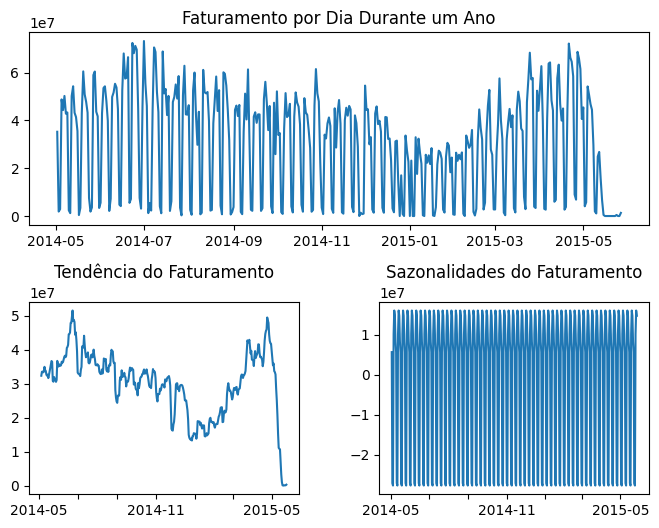

In [231]:
data_series_day=data_series.resample('D').sum()

decomposicao = seasonal_decompose(data_series_day)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal

fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ax=fig.add_subplot(2,1,1)
ax.set_title('Faturamento por Dia Durante um Ano')
plt.plot(data_series_day)

ax=fig.add_subplot(2,2,3)

ax.set_title('Tendência do Faturamento')
plt.plot(tendencia)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)


ax=fig.add_subplot(2,2,4)
ax.set_title('Sazonalidades do Faturamento')
plt.plot(sazonal)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)

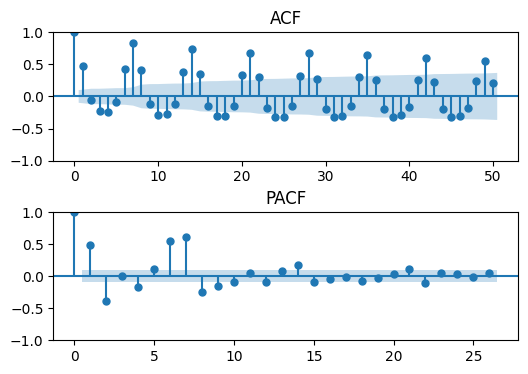

In [232]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0, hspace=0.4)


ax=fig.add_subplot(2,1,1)
plot_acf(data_series_day,title='ACF',lags=50,alpha=.05,ax=ax)

ax=fig.add_subplot(2,1,2)
plot_pacf(data_series_day,title='PACF',ax=ax)

plt.show()

c:\Users\Marcio\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\Marcio\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


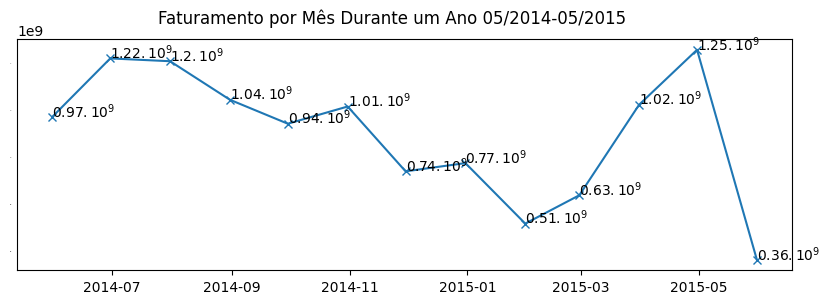

In [233]:
fig=plt.figure(figsize=(10,3))


#------------------------------------------------------------------
ax=fig.add_subplot(1,1,1)
fig.suptitle('Faturamento por Mês Durante um Ano 05/2014-05/2015')

data_series_mes=data_series.resample('M').sum()
plt.plot(data_series_mes, 'x-')

plt.tick_params(axis='y', labelsize=0, length=0)
aux=[datetime.datetime.strptime(i.isoformat()[:10],'%Y-%m-%d') for i in data_series_mes.index]
for i in aux:
    plt.text(i, data_series_mes.loc[i], f"{round(data_series_mes.loc[i].values[0]/1000000000,2)}"+r'$.10^{9}$')

Conseguimos ver uma tendência de queda entre 06/2014-01/2015. Por ser apenas uma ano, não conseguimos aplicar a decomposição para analisar a tendencia geral em relação ao ano, e nem a sazonalidade

# Funções auxiliares 

In [234]:
def prob(data, acu):
    aux=np.zeros(data.shape[0])
    
    #marcando no data frame valores que estao no vetor de acumulados
    data_aux=data.isin({'price':acu})
    
    
    #pegando os indices dos valores que estao no vetor acumulados
    indices=data[data_aux.price].index

    for i in indices:
        aux[i]=1
    return aux

In [235]:
def acumulativo(serie, porcentagem):
    #essa função recebe uma serie e porcentagem, e retornará um vetor tal que a soma de suas
    #frequencias sejam <=porcentagem, alem da soma das probabilidades desses valores e o maior a aparecer
    #obs: valores em vec não se repetem
    vec=[]
    cont=serie.value_counts(normalize=True)
    values=pd.DataFrame(cont.index)
    #ordenando os valores, pois se nao pegar na ordem de menor para maior valor de price, acabará pulando valores
    #na contagem do acumulado
    order=pd.DataFrame(values.sort_values(by=0, ascending=True).reset_index(drop=True))
    acu=0
    for i in order.values:
        value=i[0]
        acu+=cont.loc[value]
        if(acu>porcentagem):
            break
        else:
            vec.append(value)
    return np.resize(vec,(serie.shape[0])), acu, max(vec)[0]
            
          

# **Visuzalização Geral dos dados**

Vamos verificar a distribuição do preço, não apenas para a regressão, mas tambem para os tratamentos dos seu valores como outliers

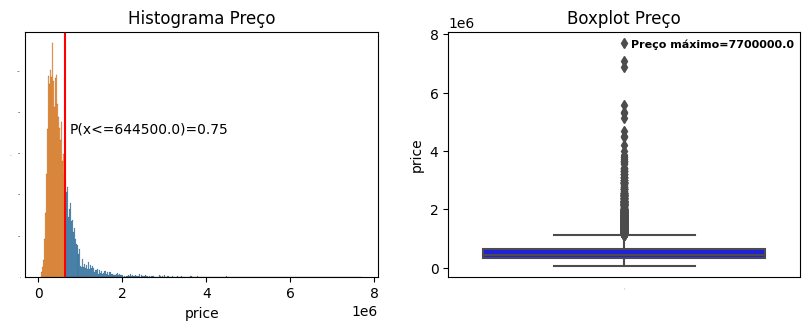

In [236]:
#fazendo uma copia com apenas a coluna que interessa
df_aux=df['price'].copy()
df_aux=pd.DataFrame(df_aux)

#fator de probabilidade
probi=0.75

#funções auxiliares
aux, acu, maxi=acumulativo(df_aux, probi)
df_aux.insert(1,'bool',prob(df_aux, aux))


fig=plt.figure(figsize=(10,7))


#histograma
ax=fig.add_subplot(2,2,1)
ax.set_title('Histograma Preço')
sns.histplot(data=df_aux[["price","bool"]],x="price",hue="bool",multiple="stack", legend=False)
plt.ylabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.axvline(x=maxi, ymin=0, ymax=700, color='red')
plt.text(maxi+100000, 700, f"""P(x<={maxi})={probi}""")



#boxplot
ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot Preço')
sns.boxplot(y="price",data=df,color='blue')
plt.xlabel([], fontsize=0)
plt.tick_params(axis='x', labelsize=0, length=0)

maximo=df['price'].max()
plt.text(0.02, maximo-150000, f"Preço máximo={maximo}", weight="bold",size=8)

plt.show()

In [237]:
print("media = ",df.price.mean())
print("variancia = ",df.price.var())

media =  540144.5537763791
variancia =  134797795273.55241


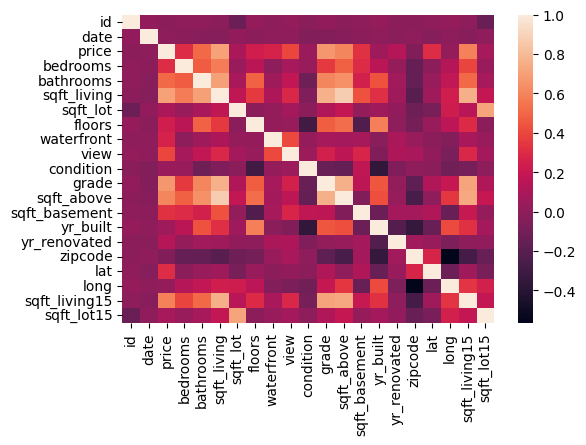

In [238]:

corr_df = df.corr(method='pearson')

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=False)
plt.show()

Text(0.5, 0, 'sqft_living')

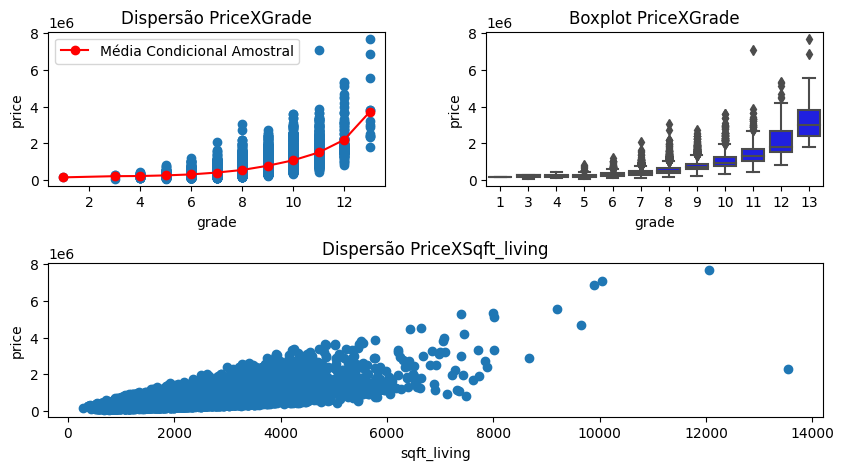

In [239]:
grop=df[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

ax=fig.add_subplot(2,2,1)
plt.plot(grop.index,grop.price, 'o-', color='red',label='Média Condicional Amostral')
plt.legend()
ax.set_title('Dispersão PriceXGrade')
plt.scatter(df.grade,df.price)
plt.ylabel('price')
plt.xlabel('grade')


ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot PriceXGrade')
sns.boxplot(x="grade",y="price",data=df,color='blue')






ax=fig.add_subplot(2,1,2)
ax.set_title('Dispersão PriceXSqft_living')
plt.scatter(df.sqft_living,df.price)
plt.ylabel('price')
plt.xlabel('sqft_living')






In [240]:
y = df['price'].values
df['price'] = stats.boxcox(df.price)[0]

Text(0.5, 0, 'sqft_living')

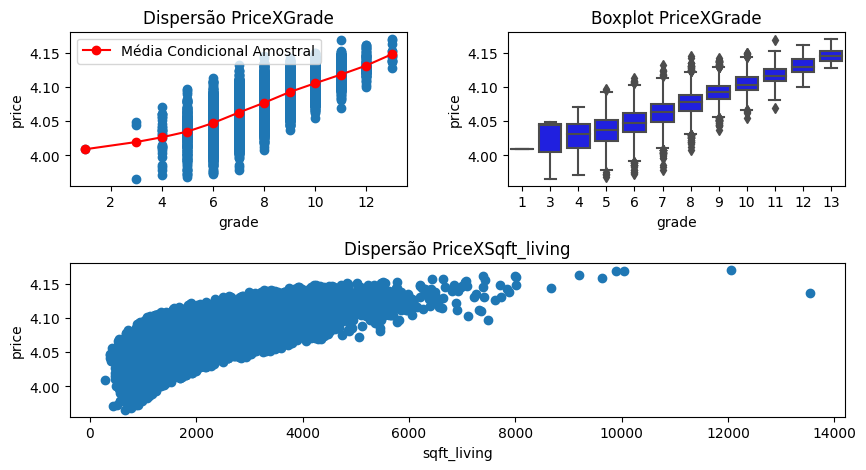

In [241]:
grop=df[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

ax=fig.add_subplot(2,2,1)
plt.plot(grop.index,grop.price, 'o-', color='red',label='Média Condicional Amostral')
plt.legend()
ax.set_title('Dispersão PriceXGrade')
plt.scatter(df.grade,df.price)
plt.ylabel('price')
plt.xlabel('grade')


ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot PriceXGrade')
sns.boxplot(x="grade",y="price",data=df,color='blue')






ax=fig.add_subplot(2,1,2)
ax.set_title('Dispersão PriceXSqft_living')
plt.scatter(df.sqft_living,df.price)
plt.ylabel('price')
plt.xlabel('sqft_living')

In [242]:
df['price'] = y

In [243]:
for i in range(7):
    aux = np.ndarray(len(df))
    for index in range(len(df)):
        data = df['date'][index]

        if(data >= data_series_day.index[i+1]):
            
            aux[index] = data_series_day.loc[data-datetime.timedelta(days=i)]
        else:
            aux[index] = 0
    df[f'i-{i+1}'] = aux


C:\Users\Marcio\AppData\Local\Temp\ipykernel_2896\2114387331.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux[index] = data_series_day.loc[data-datetime.timedelta(days=i)]


C:\Users\Marcio\AppData\Local\Temp\ipykernel_2896\2114387331.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux[index] = data_series_day.loc[data-datetime.timedelta(days=i)]
C:\Users\Marcio\AppData\Local\Temp\ipykernel_2896\2114387331.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux[index] = data_series_day.loc[data-datetime.timedelta(days=i)]
C:\Users\Marcio\AppData\Local\Temp\ipykernel_2896\2114387331.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux[index] = data_series_day.loc[data-datetime.timedelta(days=i)]
C:\Users\Marcio\AppData\Local\Temp\ipykernel_2896\2114387331.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in

In [244]:
df[['date','i-1','i-2','i-3','i-4']]

,date,i-1,i-2,i-3,i-4
0,2014-05-02,0.0,0.0,0.0,0.0
1,2014-05-02,0.0,0.0,0.0,0.0
2,2014-05-02,0.0,0.0,0.0,0.0
3,2014-05-02,0.0,0.0,0.0,0.0
4,2014-05-02,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21603,2015-05-14,6637799.0,15860340.0,26830875.0,24870260.0
21604,2015-05-14,6637799.0,15860340.0,26830875.0,24870260.0
21605,2015-05-15,450000.0,6637799.0,15860340.0,26830875.0
21606,2015-05-24,445500.0,0.0,0.0,0.0


In [245]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,i-1,i-2,i-3,i-4,i-5,i-6,i-7
0,5561000190,2014-05-02,437500.0,3.0,2,1970,35100,2,0,0,...,-121.991,2340,35100,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,472000620,2014-05-02,790000.0,3.0,2,2600,4750,1,0,0,...,-122.400,2380,4750,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024069009,2014-05-02,675000.0,5.0,2,2820,67518,2,0,0,...,-122.025,2820,48351,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7853361370,2014-05-02,555000.0,4.0,2,3310,6500,2,0,0,...,-121.870,2380,5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5056500260,2014-05-02,440000.0,4.0,2,2160,8119,1,0,0,...,-122.177,1850,9000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21603,1422700040,2015-05-14,183000.0,3.0,1,1170,7320,1,0,0,...,-122.282,2040,7320,6637799.0,15860340.0,26830875.0,24870260.0,1085000.0,1916500.0,29663400.0
21604,8730000270,2015-05-14,359000.0,2.0,2,1370,1140,2,0,0,...,-122.343,1370,1090,6637799.0,15860340.0,26830875.0,24870260.0,1085000.0,1916500.0,29663400.0
21605,7923600250,2015-05-15,450000.0,5.0,2,1870,7344,1,0,0,...,-122.144,1870,7650,450000.0,6637799.0,15860340.0,26830875.0,24870260.0,1085000.0,1916500.0
21606,5101400871,2015-05-24,445500.0,2.0,1,1390,6670,1,0,0,...,-122.308,920,6380,445500.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rede Neural

In [246]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'i-1', 'i-2', 'i-3',
       'i-4', 'i-5', 'i-6', 'i-7'],
      dtype='object')

In [247]:
scale_price = StandardScaler()
scale_price.fit(df['price'].values.reshape(len(df),1))
df['price'] = scale_price.transform(df['price'].values.reshape(len(df),1))


scale_sqft = StandardScaler()
scale_sqft.fit(df['sqft_living'].values.reshape(len(df),1))
df['sqft_living'] = scale_sqft.transform(df['sqft_living'].values.reshape(len(df),1))


scale_condition = StandardScaler()
scale_condition.fit(df['condition'].values.reshape(len(df),1))
df['condition'] = scale_sqft.transform(df['condition'].values.reshape(len(df),1))


scale_grade = StandardScaler()
scale_grade.fit(df['grade'].values.reshape(len(df),1))
df['grade'] = scale_sqft.transform(df['grade'].values.reshape(len(df),1))


scale_zip = StandardScaler()
scale_zip.fit(df['zipcode'].values.reshape(len(df),1))
df['zipcode'] = scale_sqft.transform(df['zipcode'].values.reshape(len(df),1))


for column in [ 'i-1', 'i-2', 'i-3','i-4', 'i-5', 'i-6', 'i-7']:
    df[column] = scale_price.transform(df[column].values.reshape(len(df),1))

In [248]:
X_df = df[['sqft_living', 'condition', 'grade', 'zipcode', 'i-1', 'i-2', 'i-3',
       'i-4', 'i-5', 'i-6', 'i-7']]
Y_df = df['price']
X_df

,sqft_living,condition,grade,zipcode,i-1,i-2,i-3,i-4,i-5,i-6,i-7
0,-0.119756,-2.260282,-2.254838,104.464463,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224
1,0.566171,-2.260282,-2.254838,104.562453,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224
2,0.805701,-2.261371,-2.255927,104.466641,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224
3,1.339200,-2.261371,-2.255927,104.505837,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224
4,0.087111,-2.261371,-2.255927,104.441599,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224
...,...,...,...,...,...,...,...,...,...,...,...
21603,-0.990774,-2.261371,-2.257016,104.639756,16.608540,41.728518,71.609610,66.269367,1.484055,3.748860,79.324725
21604,-0.773019,-2.261371,-2.255927,104.579873,16.608540,41.728518,71.609610,66.269367,1.484055,3.748860,79.324725
21605,-0.228633,-2.261371,-2.257016,104.442688,-0.245532,16.608540,41.728518,71.609610,66.269367,1.484055,3.748860
21606,-0.751244,-2.261371,-2.258105,104.560275,-0.257789,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224,-1.471224


In [249]:
X_train,X_test = X_df[:int(len(df)*0.8)], X_df[int(len(df)*0.8):]
Y_train,Y_test = Y_df[:int(len(df)*0.8)], Y_df[int(len(df)*0.8):]

In [260]:
model = keras.Sequential([
    keras.layers.Dense(11,activation='relu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(11,activation='relu'),
    keras.layers.Dense(11,activation='relu'),
    keras.layers.Dense(1)
])

In [261]:
optimizer = keras.optimizers.RMSprop(0.1,)
model.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [262]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs = 500,
    verbose = 0
)

In [263]:
hist_df = pd.DataFrame(history.history)

([<matplotlib.axis.XTick at 0x2108feefad0>,
 [Text(0, 0, '0'), Text(100, 0, '100')])

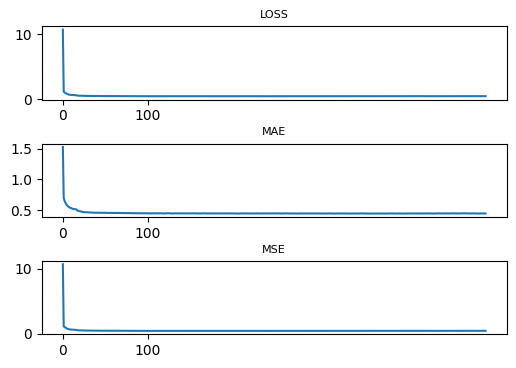

In [264]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist_df.loss)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist_df.mae)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist_df.mse)
plt.xticks([0,100])

In [265]:
metrics = model.evaluate(X_test,Y_test)
print(f"Loss = {metrics[0]}")
print(f"MAE = {metrics[1]}")
print(f"MSE = {metrics[2]}")
print(f"MAPE = {metrics[3]}")

136/136 [==============================] - 2s 5ms/step - loss: 0.5726 - mae: 0.5157 - mse: 0.5726 - mape: 747.0222
Loss = 0.5725853443145752
MAE = 0.5156848430633545
MSE = 0.5725853443145752
MAPE = 747.022216796875


In [266]:
predict = model.predict(X_test).flatten()

136/136 [==============================] - 1s 3ms/step


In [267]:
residuos = Y_test-predict

Text(0.5, 0, 'Previsão')

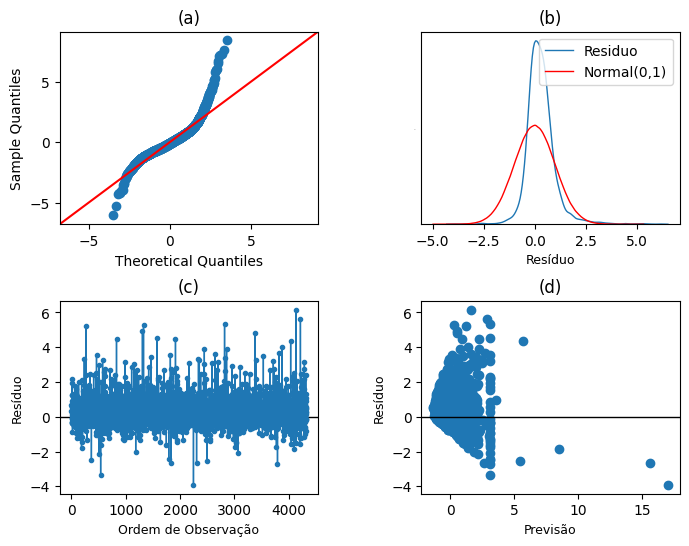

In [268]:
fig=plt.figure(figsize=(8,6))
titulo = ['(a)','(b)','(c)','(d)']
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)
ax.set_title(titulo[2])
plt. axhline(y=0,xmin=0,xmax=len(residuos),color='black', linewidth=1)
plt.plot(range(len(residuos)),residuos,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,2,2)
ax.set_title(titulo[1])
sns.kdeplot(residuos,label="Residuo", linewidth=1)
normal = np.random.normal(0, 1,2000000)
sns.kdeplot(normal,label='Normal(0,1)', linewidth=1,color='red')
plt.legend()
plt.yticks([])
plt.ylabel([], fontsize=0)
plt.xlabel('Resíduo',fontsize=9)

ax=fig.add_subplot(2,2,1)
ax.set_title(titulo[0])
sm.qqplot(residuos,fit=True,line='45',ax=ax)

ax=fig.add_subplot(2,2,4)
ax.set_title(titulo[3])
plt.scatter(predict,residuos)
plt.axhline(y=0,xmin=0,xmax=len(predict),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)